---

# Tabular Data in Fastai2

---

## Setup:

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# !git clone https://github.com/fastai/fastbook.git '/content/drive/My Drive/fastbook'

In [0]:
# !git config --global user.email "harish3110@gmail.com"
# !git config --global user.name "Harish Vadlamani"

In [0]:
# !cd '/content/drive/My Drive/course-v4' && git stash save && git pull
# !cd '/content/drive/My Drive/fastbook' && git stash save && git pull

In [0]:
# !pip install fastai2

In [0]:
# %cd '/content/drive/My Drive/fastbook'
# !pip install -r requirements.txt

In [8]:
%cd '/content/'
!ls
!mv kaggle.json ~/.kaggle/

/content
drive  kaggle.json  sample_data


In [9]:
!pip install dtreeviz

In [0]:
# from utils import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai2.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

---

## Getting the data

In [12]:
!mkdir bluebook
%cd '/content/bluebook'

/content/bluebook


In [13]:
path = Path('/content/bluebook')
path

Path('/content/bluebook')

In [0]:
Path.BASE_PATH = path

In [15]:
!kaggle competitions download -c bluebook-for-bulldozers
!ls

  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 42.6MB/s]
  0% 0.00/209k [00:00<?, ?B/s]
100% 209k/209k [00:00<00:00, 69.6MB/s]
100% 5.00M/5.01M [00:00<00:00, 12.1MB/s]
100% 5.01M/5.01M [00:00<00:00, 11.3MB/s]
 53% 5.00M/9.38M [00:00<00:00, 9.96MB/s]
100% 9.38M/9.38M [00:00<00:00, 17.4MB/s]
  0% 0.00/297k [00:00<?, ?B/s]
100% 297k/297k [00:00<00:00, 43.3MB/s]
  0% 0.00/338k [00:00<?, ?B/s]
100% 338k/338k [00:00<00:00, 47.7MB/s]
  0% 0.00/291k [00:00<?, ?B/s]
100% 291k/291k [00:00<00:00, 96.1MB/s]
 52% 5.00M/9.59M [00:00<00:00, 10.6MB/s]
100% 9.59M/9.59M [00:00<00:00, 17.8MB/s]
 71% 5.00M/7.06M [00:00<00:00, 16.1MB/s]
100% 7.06M/7.06M [00:00<00:00, 19.9MB/s]
 73% 5.00M/6.85M [00:00<00:00, 16.9MB/s]
100% 6.85M/6.85M [00:00<00:00, 19.7MB/s]
  0% 0.00/207k [00:00<?, ?B/s]
100% 207k/207k [00:00<00:00, 66.7MB/s]
  0% 0.00/192k [00:00<?, ?B/s]
100% 192k/192k [00:00<00:00, 65.5MB/s]
 54% 5.00M/9.28M [00:00<00:00, 10.3MB/s]
100% 9.28M/9.28M [00:00<00:00, 17.2MB/s]
  0% 0.00/10.8k [0

In [16]:
!unzip TrainAndValid.csv.zip
!unzip Test.csv.zip
!unzip Valid.csv.zip

Archive:  TrainAndValid.csv.zip
  inflating: TrainAndValid.csv       
Archive:  Test.csv.zip
  inflating: Test.csv                
Archive:  Valid.csv.zip
  inflating: Valid.csv               


In [17]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


In [18]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

## Cleaning Data

### Setting ordinal column 'ProductSize'

In [0]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [20]:
df['ProductSize'].head()

0       NaN
1    Medium
2       NaN
3     Small
4       NaN
Name: ProductSize, dtype: category
Categories (6, object): [Large < Large / Medium < Medium < Small < Mini < Compact]

### Setting dependant variable

In [0]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

### Handling dates

Using fastai's `add_datepart` method

In [0]:
df = add_datepart(df, 'saledate')

In [0]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [24]:
# Viewing the meta columns added by the `add_datepart` method
', '.join(o for o in df.columns if o.startswith('sale'))

'saleYear, saleMonth, saleWeek, saleDay, saleDayofweek, saleDayofyear, saleIs_month_end, saleIs_month_start, saleIs_quarter_end, saleIs_quarter_start, saleIs_year_end, saleIs_year_start, saleElapsed'

## TabularPandas

### TabularProc

In [0]:
# Using TabularProc to apply necessary transforms to tabular data
procs = [Categorify, FillMissing]

### Splitting condition

In [0]:
# Setting the splitting criteria for test and validation set
# Here defining train set for all sales prior to November 2011 using the Saleyear and SaleMonth columns extracted from `add_datepart` on Saledate

cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

### Defining the categorical and continuous variables

In [0]:
cont_cat_split??

In [0]:
# TabularPandas needs to know specifically which columns are continous and which are categorical
# Fastai has a built-in method `cont_cat_split` which can find out this by checking the features cardinality

cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

# Here '1' indicates max_cardinality of 1? This also checks whether datatype is float. If so they are continuous directly.
# By default max_cardinality is 20 for cont_cat_split

In [29]:
cont

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleElapsed']

In [30]:
cat

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start']

### Building the TabularPandas

In [105]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

KeyError: ignored

In [32]:
len(to.train),len(to.valid)

(404710, 7988)

In [33]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246.0,999089.0,3157.0,121.0,3.0,2004.0,68.0,2006.0,11.0,46.0,16.0,3.0,320.0,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248.0,117657.0,77.0,121.0,3.0,1996.0,4640.0,2004.0,3.0,13.0,26.0,4.0,86.0,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249.0,434808.0,7009.0,121.0,3.0,2001.0,2838.0,2004.0,2.0,9.0,26.0,3.0,57.0,1.077754e+09,9.210340


In [34]:
# Numerically encoded head view
to.items[['UsageBand', 'fiModelDesc' ]].head(3)

,UsageBand,fiModelDesc
0,2,958
1,2,1737
2,1,334


In [35]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246.0,11.097410,999089.0,3157.0,...,1,1.163635e+09,1,1
1,1139248.0,10.950807,117657.0,77.0,...,1,1.080259e+09,1,1
2,1139249.0,9.210340,434808.0,7009.0,...,1,1.077754e+09,1,1


### Saving and loading TabularPandas

In [0]:
# Save
(path/'to.pkl').save(to)

In [0]:
# Load
to = (path/'to.pkl').load()

### Splitting data

In [0]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

### Dtreeviz

In [0]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

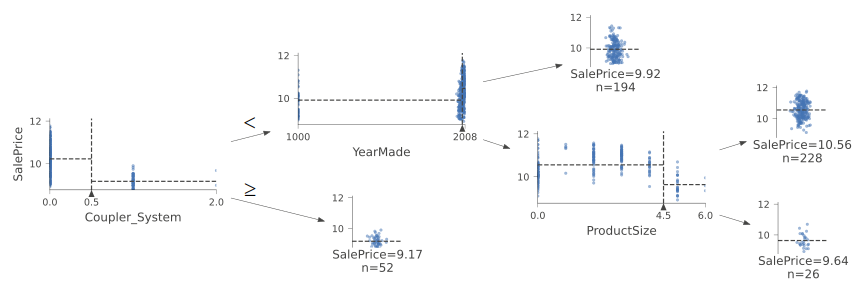

In [40]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [0]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

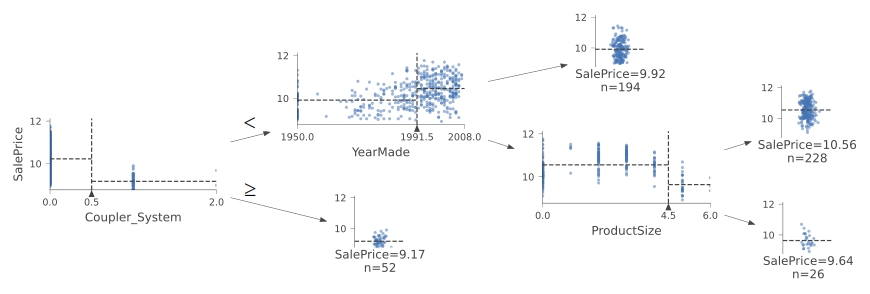

In [42]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

## Random Forests

In [0]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [0]:
m = rf(xs, y);

In [0]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [46]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171019, 0.233597)

### Cross Validation

In [47]:
# Using cross validation
scores = cross_val_score(estimator=m,
                         X=xs,
                         y=y,
                         cv=3,
                         n_jobs=-1, 
                         scoring='neg_root_mean_squared_error')

print(f'RMSE: {scores}')
print(f'RMSE: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Variance Error: {np.var(scores)}')

RMSE: [-0.27685459 -0.28999669 -0.31088256]
RMSE: -0.293 +/- 0.014
Variance Error: 0.0001963152281267751


### Number of trees

In [0]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [49]:
r_mse(preds.mean(0), valid_y)

0.233597

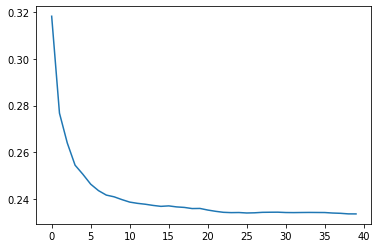

In [50]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out of bag Error

In [51]:
r_mse(m.oob_prediction_, y)

0.210911

The oob error is lesser than validation error which suggests that there is some other causing the error other than generalization error

## Model Interpretation

### Tree variance to check prediction confidence

In [52]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(40, 7988)

40 Trees and their predictions for the 7988 rows of data

In [53]:
# Getting standard deviations over all trees for each auction
preds_std = preds.std(0)
preds_std.shape

(7988,)

In [54]:
preds_std[:5]

array([0.32658793, 0.09528282, 0.12712997, 0.25706942, 0.13773645])

We can see that the confidence of predictions over all trees for each row of data varies. For instance the 1st row of data theres a std of 0.26 as compared to 0.11 for the second row hwich means that the RF is more confident of the 2nd row of data. 

This info can be used during inference to see how confident we can be aboput our predictions.  

### Feature Importance

In [0]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [56]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.173619
6,ProductSize,0.119818
30,Coupler_System,0.078938
32,Hydraulics_Flow,0.074905
7,fiProductClassDesc,0.064386
54,ModelID,0.056039
31,Grouser_Tracks,0.052937
65,saleElapsed,0.049654
3,fiSecondaryDesc,0.048969
1,fiModelDesc,0.030742


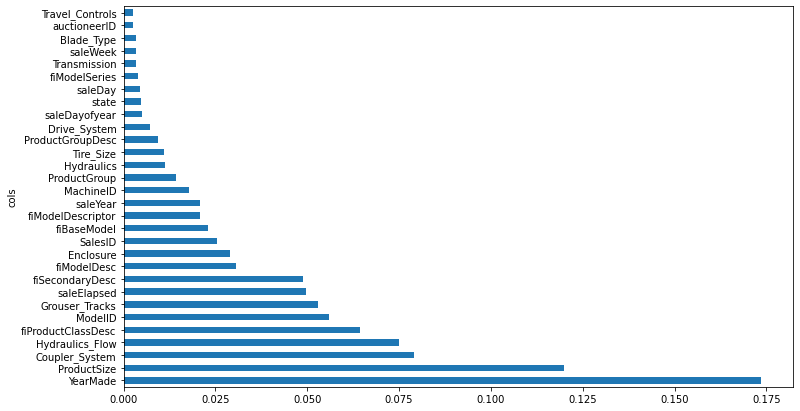

In [57]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing low-importance features

In [58]:
to_keep = fi['cols'][fi['imp'] > 0.005].values
to_keep

array(['YearMade', 'ProductSize', 'Coupler_System', 'Hydraulics_Flow',
       'fiProductClassDesc', 'ModelID', 'Grouser_Tracks', 'saleElapsed',
       'fiSecondaryDesc', 'fiModelDesc', 'Enclosure', 'SalesID',
       'fiBaseModel', 'fiModelDescriptor', 'saleYear', 'MachineID',
       'ProductGroup', 'Hydraulics', 'Tire_Size', 'ProductGroupDesc',
       'Drive_System'], dtype=object)

In [0]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [0]:
m = rf(xs_imp, y)

In [61]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181085, 0.23179)

In [62]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

### Removing redundant features
Using fastai's `cluster_columns` method which does a hierarchical clustering

In [104]:
cluster_columns(xs_imp)

NameError: ignored

In [0]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [107]:
# Our baseline to check when removing possible redundant features
get_oob(xs_imp)

0.877589225307897

In [108]:
# Dropping one columns at a time
redundant_cols = ['saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System']

{c:get_oob(xs_imp.drop(c, axis=1)) for c in redundant_cols}

{'Coupler_System': 0.8774645009445562,
 'Grouser_Tracks': 0.8770717422842595,
 'Hydraulics_Flow': 0.8783026641851623,
 'ProductGroup': 0.8776523006487674,
 'ProductGroupDesc': 0.8782045378786261,
 'fiBaseModel': 0.8759158342272576,
 'fiModelDesc': 0.8761711032832339,
 'saleElapsed': 0.8734898972035029,
 'saleYear': 0.8766791664519571}

In [109]:
# Dropping multiple columsn at a time
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8747409890363835

In [0]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [111]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183235, 0.232974)

###Partial dependance
>Check how each feature affects the prediction of dependant variable considering all else is equal

- If a row varied on nothing other than itself, how would it impact the predictions of the dependant varibale?

- How?:
  - Replace all values of a certain column, say 'YearMade' with the starting range which is '1950', calculate the predictions and average them.
  - Do this for the entire range of 'YearMade' and finally plot these apartial dependance values against the year

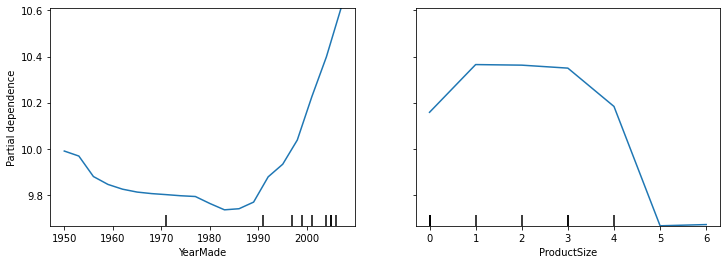

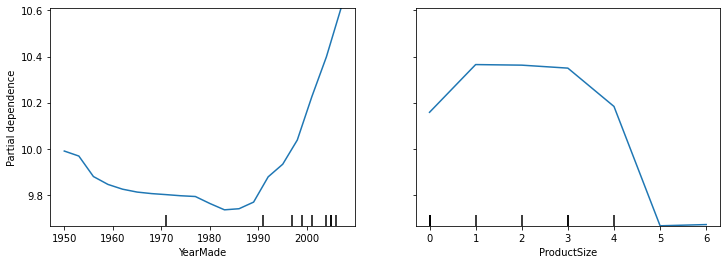

In [112]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

### Tree interpreter

In [113]:
!pip install treeinterpreter
!pip install waterfallcharts

In [0]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [0]:
row = valid_xs_final.iloc[:5]

In [0]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [118]:
prediction[0], bias[0], contributions[0].sum()

(array([10.03464052]), 10.104510187804987, -0.06986966641620156)

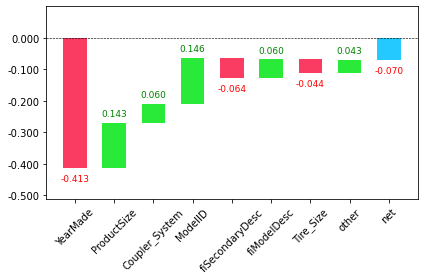

In [119]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

This kind of information is most useful in production, rather than during model development. You can use it to provide useful information to users of your data product about the underlying reasoning behind the predictions.

### Finding out of domain data

Since RF's can't extrapolate well outside the training set, i.e. it doesn't work well on out of domain data we need to ensure that the validation set is in sync with our training data. Need to make sure that the features follow the same distributions etc.

This can be done with a technique called `Adversarial Validation`.

How?
> Using a RF itself

- Use the training data as is and set their labels to '0'
- Set the validation data labels to '1'
- Concatenate them and train a RF on this binary classifcation problem

In [120]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.884725
10,SalesID,0.089888
12,MachineID,0.020926
8,fiModelDesc,0.001609
0,YearMade,0.000830
15,Tire_Size,0.000441


The feature importance of this model indicates which features are most important in distinguishing between train and validation and thus these features are the most different in the two datasets. 


This method can be used to check 'domain shift' issues in your splitting. We'll try training the original RF model, removing each of these in turn, and also checking the baseline model RMSE:

In [121]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232905
SalesID 0.231502
saleElapsed 0.235118
MachineID 0.232997


It looks like we should be able to remove SalesID and MachineID without losing any accuracy; let's check:

In [122]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.23091

Removing these variables has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand. We recommend that for all datasets you try building a model where your dependent variable is is_valid, like the above. It can often uncover subtle domain shift issues that you may otherwise miss.

## Using a neural network

In [0]:
# repeting the pre-processing steps done earlier
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [0]:
# Using the necessary cols as decided in the previous model interpreation step to build the NN model

df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [0]:
cont_cat_split??

In [0]:
# Categorical columns are handled differently in NN's. Rule of thumb limit for embedding size is 10k
# So 9k is used here as the max_card limit?

cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

However, one variable that we absolutely do not want to treat as categorical is the saleElapsed variable. A categorical variable cannot, by definition, extrapolate outside the range of values that it has seen. But we want to be able to predict auction sale prices in the future. Therefore, we need to make this a continuous variable:

In [0]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [127]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
Hydraulics_Flow          3
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
fiModelDescriptor      140
ProductGroup             6
Hydraulics              12
Tire_Size               17
Drive_System             4
dtype: int64

In [128]:
df_nn_final[cont_nn].nunique()

saleElapsed    4013
dtype: int64

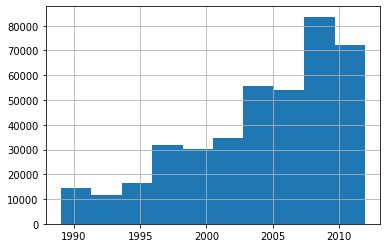

In [129]:
# Let's consider only newer data for relevance
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

xs['saleYear'].hist();

In [130]:
# Dropping 'fiModelDescriptor' since there are 2 columns pertaining to model description each with high cardinality and hence there is an assumption that the parameters will match
# Lets check if this affects rf model

xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.190839, 0.231414)

There's minimal impact, so we will remove it as a predictor for our neural network.

In [0]:
cat_nn.remove('fiModelDescriptor')

In [0]:
# For NN models unlike RF, Normalizing the features is mandatory
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [0]:
# Tabular nn can take larger batch sizes on the GPU 
dls = to_nn.dataloaders(1024)

In [134]:
# Since regression looking at y_range to help tabular learner
y = to_nn.train.y
y.min(),y.max()

(8.465899897028686, 11.863582336583399)

In [0]:
from fastai2.tabular.all import *

In [0]:
# By default the linear layers selected are with 200 and 100 activations each but since this dataset is larger using 500 and 250 respectively
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250], ps=[0.001,0.01], emb_drop=0.04, 
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.00019054606673307717)

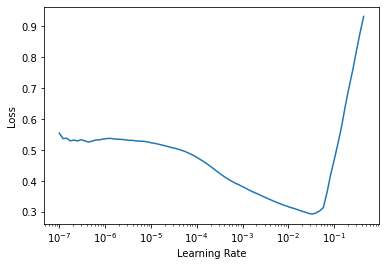

In [148]:
learn.lr_find()

In [151]:
learn.fit_one_cycle(5, 3e-3, wd=0.2)

epoch,train_loss,valid_loss,time
0,0.048314,0.054393,00:09
1,0.048638,0.053887,00:09
2,0.045562,0.053204,00:09
3,0.041681,0.051664,00:09
4,0.038327,0.051352,00:09


In [152]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.22661

## Ensembling

In [0]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [142]:
r_mse(ens_preds,valid_y)

0.223564

Ensembling slightly beats the NN model as well.

Why? Bagging works! 

In [146]:
len(cat_nn)

13

In [145]:
learn.model.embeds

ModuleList(
  (0): Embedding(73, 18)
  (1): Embedding(7, 5)
  (2): Embedding(3, 3)
  (3): Embedding(4, 3)
  (4): Embedding(75, 18)
  (5): Embedding(5242, 194)
  (6): Embedding(178, 29)
  (7): Embedding(5022, 189)
  (8): Embedding(7, 5)
  (9): Embedding(7, 5)
  (10): Embedding(13, 7)
  (11): Embedding(18, 8)
  (12): Embedding(5, 4)
)